In [2]:
%cd /content/drive/MyDrive/MLDM project

/content/drive/MyDrive/MLDM project


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Geting pretrained labels using autoincoding clustering***

In [3]:
import torchvision
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
import numpy as np
from torch.optim import lr_scheduler
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score

In [4]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models
from torch import optim
from torchvision import models
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns 

In [5]:
n_epochs = 3
batch_size_train = 512
batch_size_test = 512
lr = 0.001
momentum = 0.5
log_interval = 10
cluster_number = 10

Getting data

In [6]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
hflipper = T.RandomHorizontalFlip(p=1)

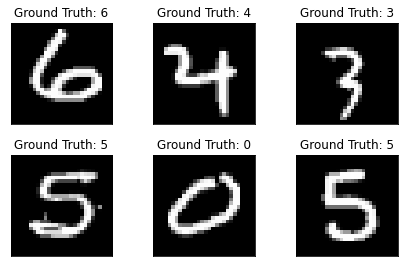

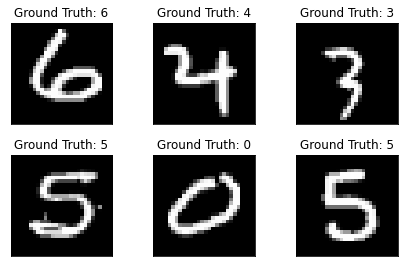

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Initializing the autoincoder model with clustering labels

In [10]:
class Autorencoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### encoder section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # nn.Conv2d(16, 32, 3, stride=2, padding=0),
            # nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ## Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ### Cluster layer
        self.cluster_layer = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 100)
        )

        ### Decoder section
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128,784),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )

        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        out = self.flatten(x)
        cluster = self.cluster_layer(out)
        x = self.encoder_lin(x)
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x, cluster, out

In [11]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':60000,
    'val':10000
}

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [13]:
def add_noise(inputs):
     noise = torch.randn_like(inputs)
     return inputs + noise

In [39]:
def train_model_model(model, criterion, optimizer, criterion_cl, epoch=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 100000.00
  best_nmi = 0.0
  batch_count = 1
  need_new_cluster = True
  psevdo_labels = None
  cluster_number = 100
  kmean = None


  for i in range(epoch):
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0
      running_loss_ai = 0.0
      running_loss_cl = 0.0

      running_corrects = []
      losses_ai = []
      losses_cl = []

      losses = []
      corrects = []

      for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()

        ### decrising the number of clusters from 100 to 10 step by step
        if  batch_count % 20 == 0 and phase == 'train':
          if cluster_number > 10:
            cluster_number = int(pow(100, (2 - (1/360)*batch_count)/2))
            need_new_cluster = True
          if cluster_number < 10:
            cluster_number = 10
          print(f'cluster number: {cluster_number}')



        


        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          probs, probs_lb, vectors = model(inputs)
          _, preds = torch.max(probs_lb, 1)
          vectors_cp = vectors.to(cpu).detach().numpy()

          if need_new_cluster:
            kmean = MiniBatchKMeans(n_clusters=cluster_number, batch_size=128, max_iter=1000, init_size=2*100)
            psevdo_labels = kmean.fit_predict(vectors_cp)
            need_new_cluster = False
          else:
            psevdo_labels = kmean.predict(vectors_cp)
          
          

          tensor_psevdo_labels = torch.from_numpy(psevdo_labels).long()
          tensor_psevdo_labels = tensor_psevdo_labels.to(device)

          loss_ai = criterion(probs,add_noise(inputs))
          loss_cl = criterion_cl(probs_lb, tensor_psevdo_labels)

          


          loss = loss_ai + loss_cl

          loss_np = loss.to(cpu).detach().numpy()

          loss_ai_np = loss_ai.to(cpu).detach().numpy()
          loss_cl_np = loss_cl.to(cpu).detach().numpy()

          preds_np = preds.to(cpu).detach().numpy()
          labels_np = labels.to(cpu).detach().numpy()

          nmi = normalized_mutual_info_score(labels_np, preds_np)

          losses.append(loss_np)
          losses_ai.append(loss_ai_np)
          losses_cl.append(loss_cl_np)
          running_corrects.append(nmi)

          batch_count += 1

         
          if (phase == 'train'):
              loss.backward()
              optimizer.step()

          

        running_loss += loss*inputs.size(0)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_loss_ai = np.mean(losses_ai)
      epoch_loss_cl = np.mean(losses_cl)
      epoch_nmi = np.mean(running_corrects)

      plt.plot(losses)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of common loss {phase}')
      plt.show()

      plt.plot(losses_ai)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of loss_ai {phase}')
      plt.show()

      plt.plot(losses_cl)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of loss_cl {phase}')
      plt.show()

      plt.plot(running_corrects)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of NMI {phase}')
      plt.show()


      print('{} Loss: {:.4f}  Loss_ai: {:.4f}  Loss_cl: {:.4f}  NMI: {:.4f} epoch: {}'.format(
          phase, epoch_loss,epoch_loss_ai,epoch_loss_cl,epoch_nmi, i ))

      # deep copy the model
      if phase == 'val' and epoch_loss <  best_epoch_loss:
          best_epoch_loss  = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(best_model_wts, './models/AICluster')

  model.load_state_dict(best_model_wts)
  return model

In [40]:
model = Autorencoder(10, 128)
criterion_ai = nn.MSELoss()
optimizer_ai = optim.Adam(model.parameters(), lr=0.0008)
criterion_cl = nn.CrossEntropyLoss()

In [41]:
model = model.to(device)

cluster number: 87
cluster number: 77
cluster number: 68
cluster number: 59
cluster number: 52


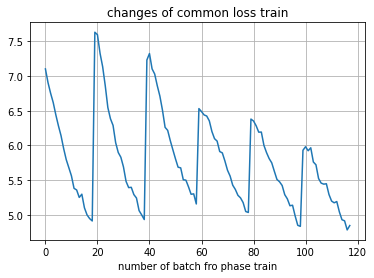

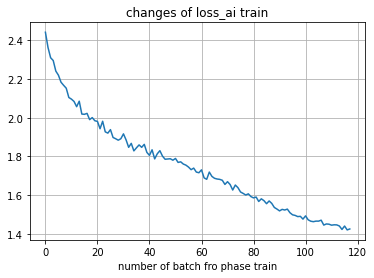

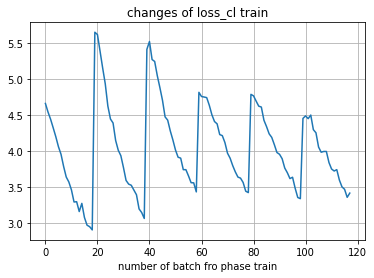

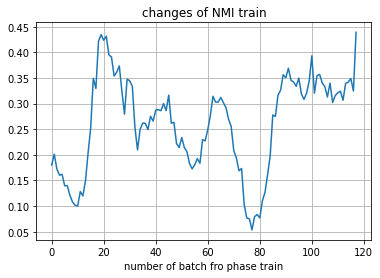

train Loss: 5.8097  Loss_ai: 1.7469  Loss_cl: 4.0562  NMI: 0.2622 epoch: 0


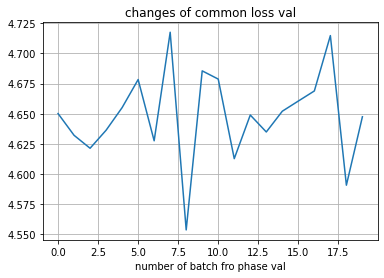

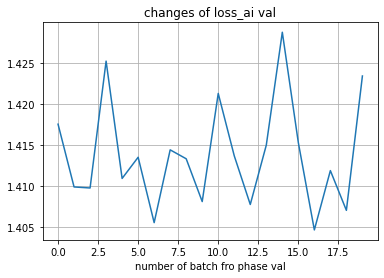

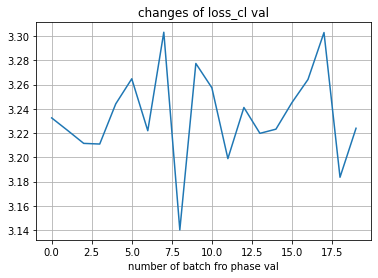

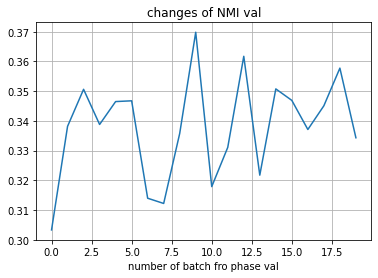

val Loss: 4.6484  Loss_ai: 1.4138  Loss_cl: 3.2345  NMI: 0.3380 epoch: 0
cluster number: 40
cluster number: 35
cluster number: 31
cluster number: 27
cluster number: 24
cluster number: 21


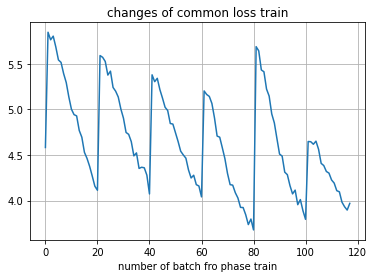

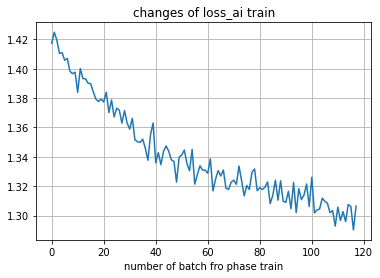

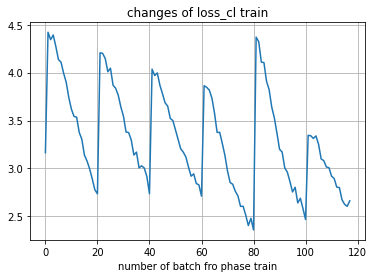

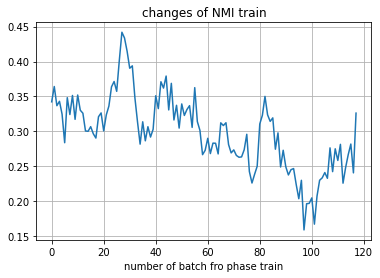

train Loss: 4.6629  Loss_ai: 1.3407  Loss_cl: 3.3174  NMI: 0.2984 epoch: 1


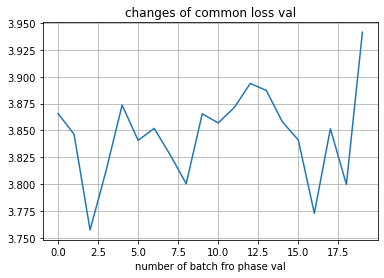

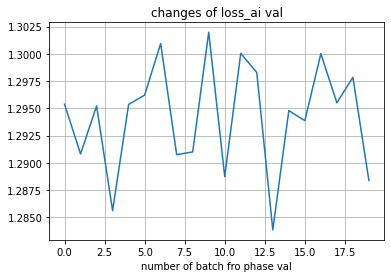

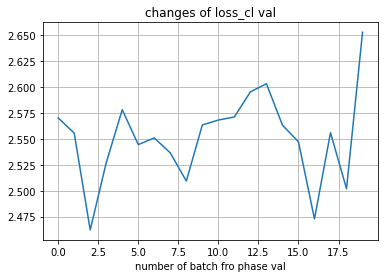

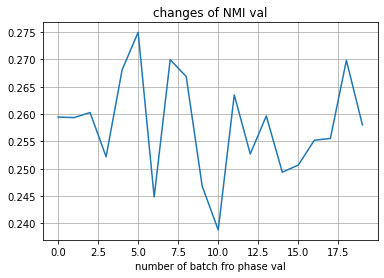

val Loss: 3.8435  Loss_ai: 1.2942  Loss_cl: 2.5515  NMI: 0.2578 epoch: 1
cluster number: 16
cluster number: 14
cluster number: 12
cluster number: 11
cluster number: 10
cluster number: 10


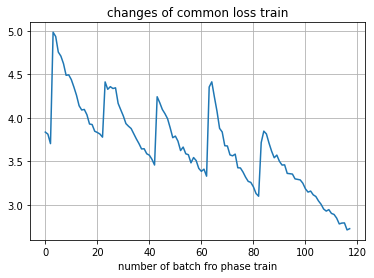

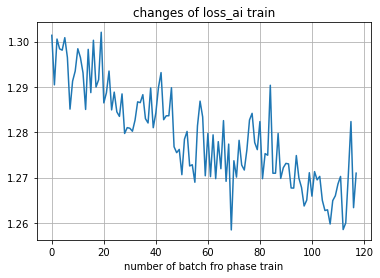

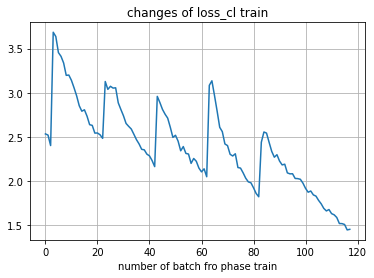

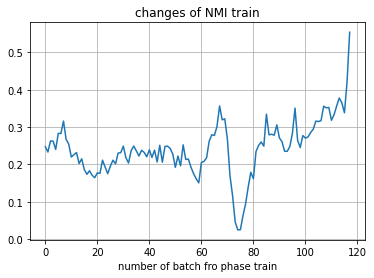

train Loss: 3.6890  Loss_ai: 1.2793  Loss_cl: 2.4031  NMI: 0.2425 epoch: 2


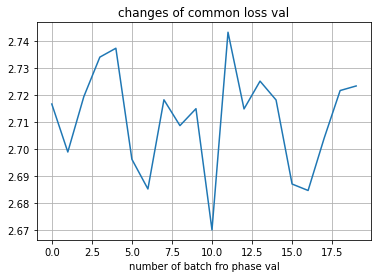

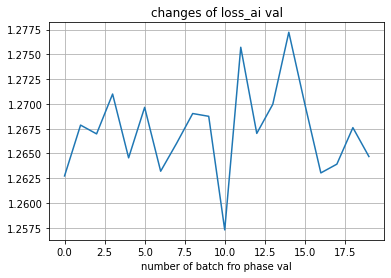

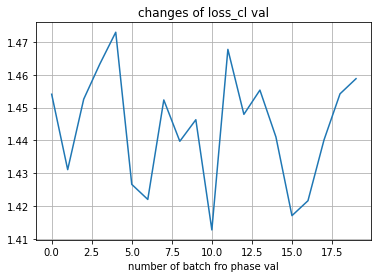

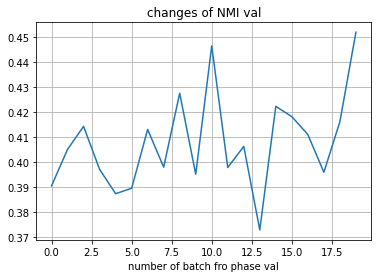

val Loss: 2.7109  Loss_ai: 1.2673  Loss_cl: 1.4439  NMI: 0.4079 epoch: 2
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


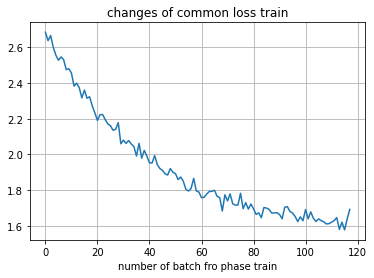

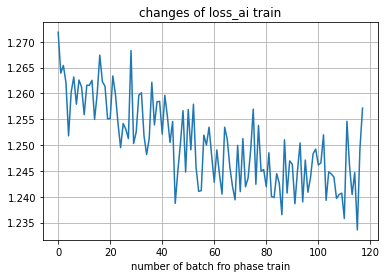

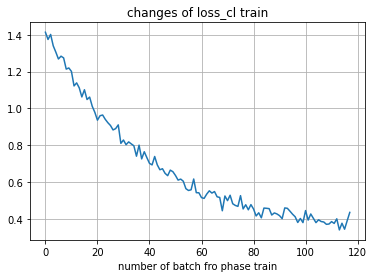

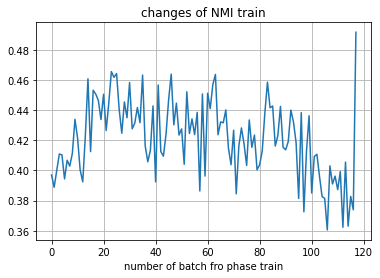

train Loss: 1.9214  Loss_ai: 1.2504  Loss_cl: 0.6694  NMI: 0.4215 epoch: 3


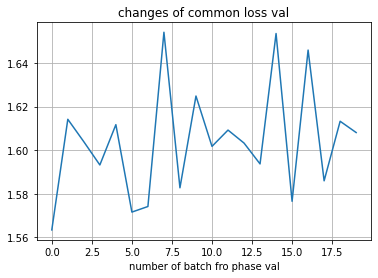

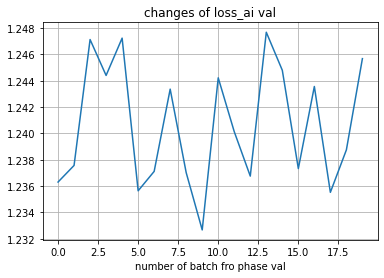

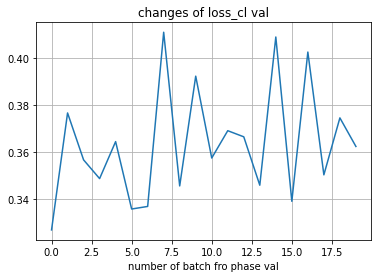

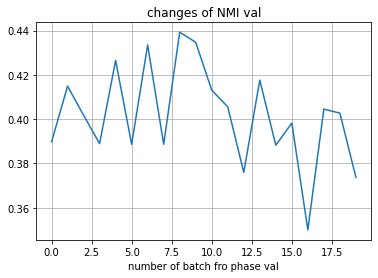

val Loss: 1.6042  Loss_ai: 1.2406  Loss_cl: 0.3636  NMI: 0.4018 epoch: 3
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


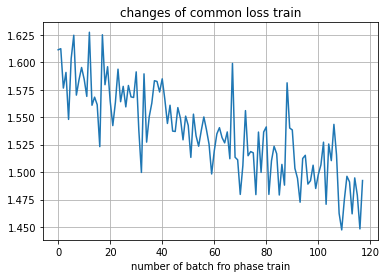

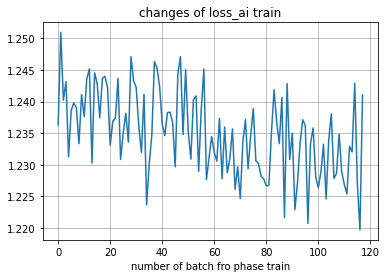

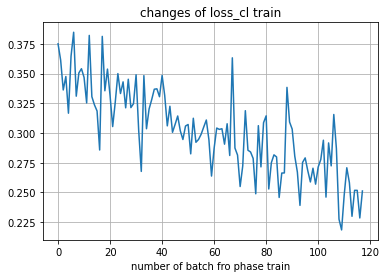

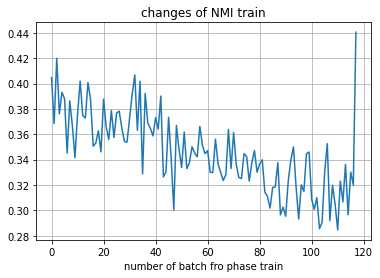

train Loss: 1.5369  Loss_ai: 1.2350  Loss_cl: 0.3016  NMI: 0.3460 epoch: 4


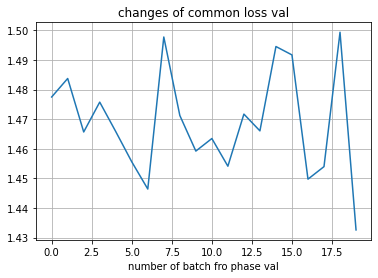

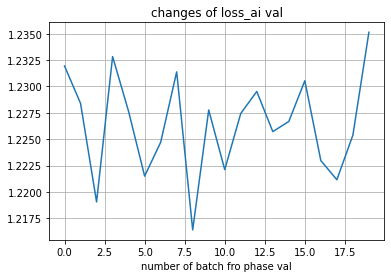

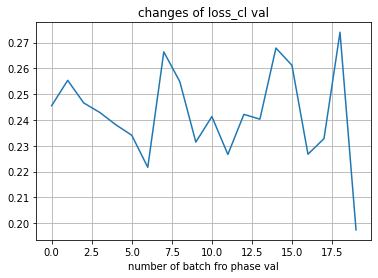

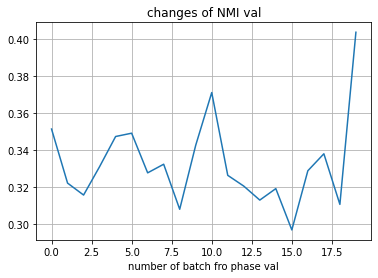

val Loss: 1.4697  Loss_ai: 1.2264  Loss_cl: 0.2424  NMI: 0.3328 epoch: 4
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


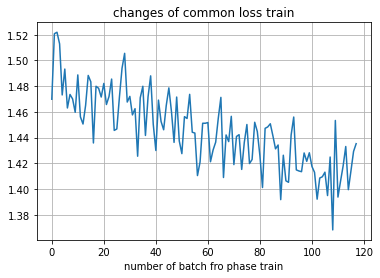

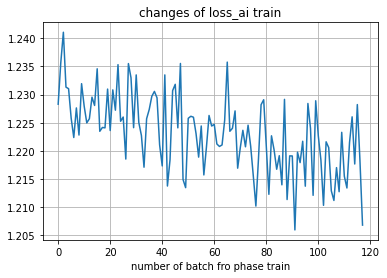

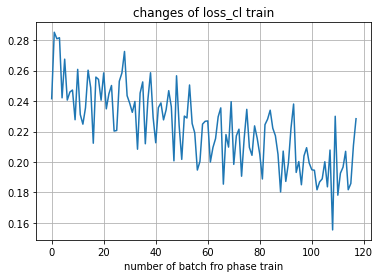

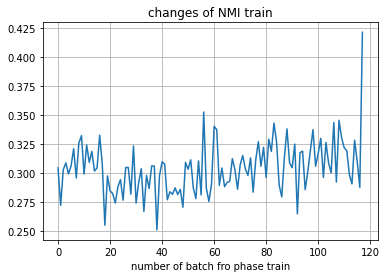

train Loss: 1.4458  Loss_ai: 1.2231  Loss_cl: 0.2226  NMI: 0.3041 epoch: 5


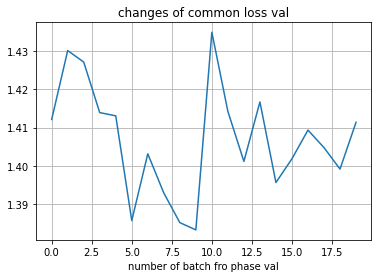

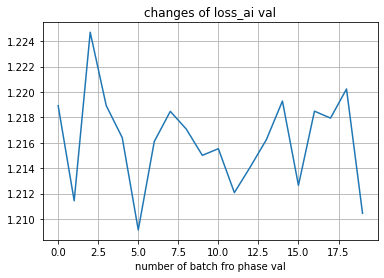

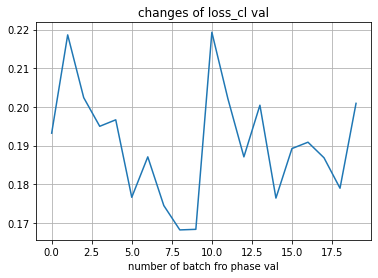

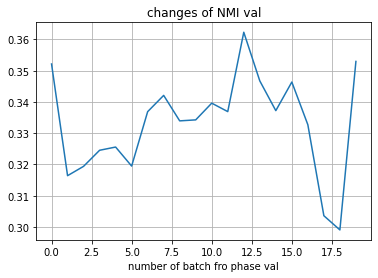

val Loss: 1.4067  Loss_ai: 1.2162  Loss_cl: 0.1906  NMI: 0.3331 epoch: 5
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


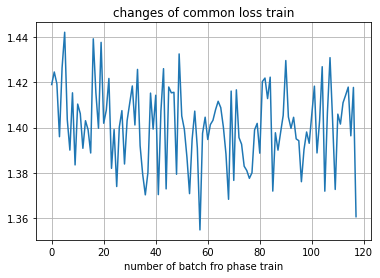

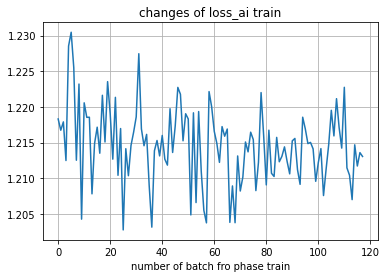

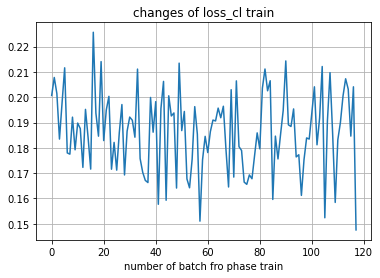

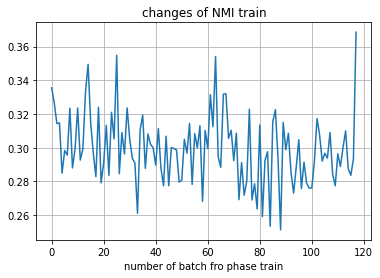

train Loss: 1.4013  Loss_ai: 1.2147  Loss_cl: 0.1863  NMI: 0.2993 epoch: 6


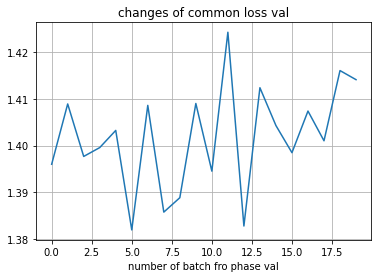

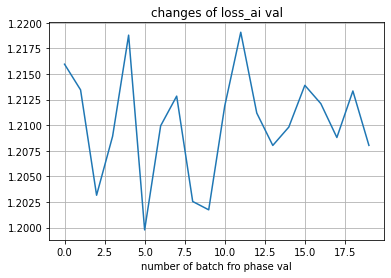

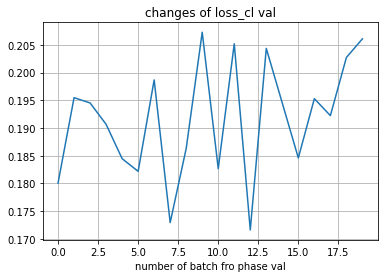

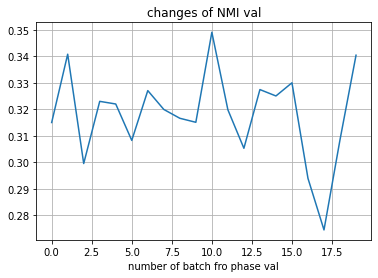

val Loss: 1.4015  Loss_ai: 1.2102  Loss_cl: 0.1916  NMI: 0.3181 epoch: 6
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


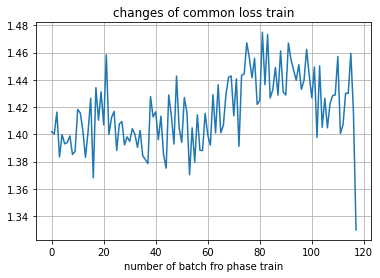

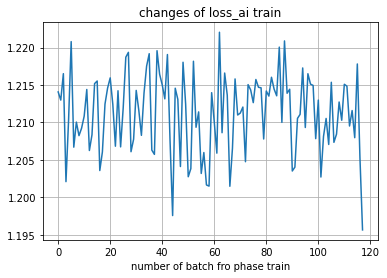

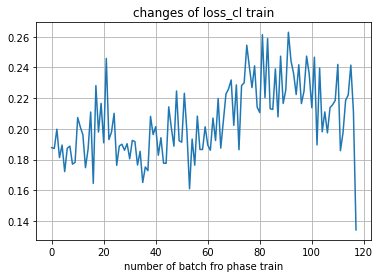

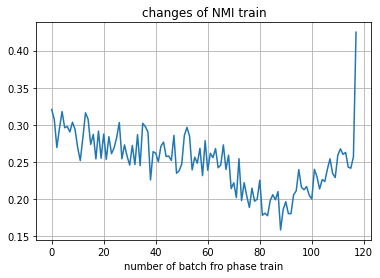

train Loss: 1.4177  Loss_ai: 1.2112  Loss_cl: 0.2059  NMI: 0.2500 epoch: 7


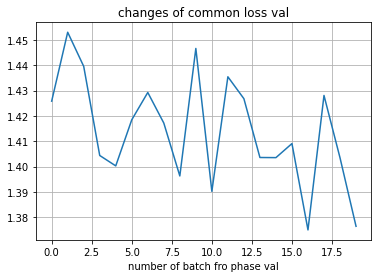

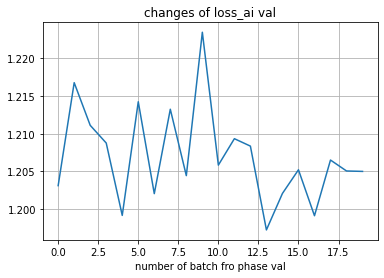

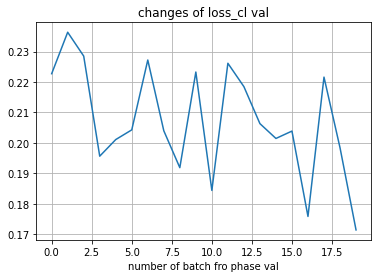

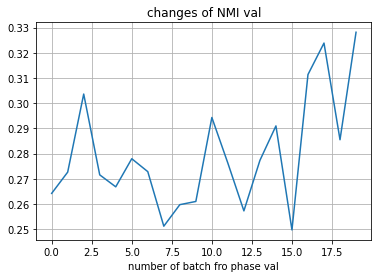

val Loss: 1.4150  Loss_ai: 1.2070  Loss_cl: 0.2071  NMI: 0.2798 epoch: 7
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


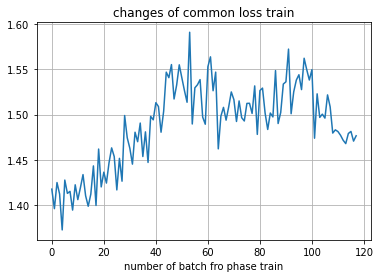

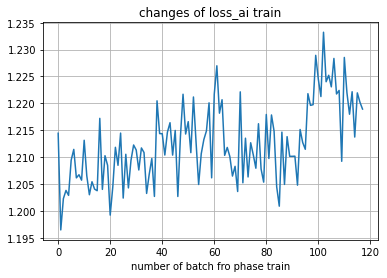

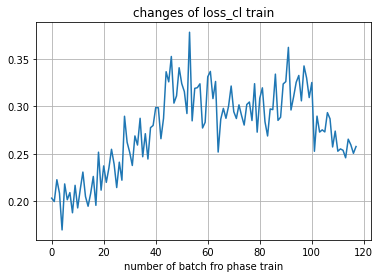

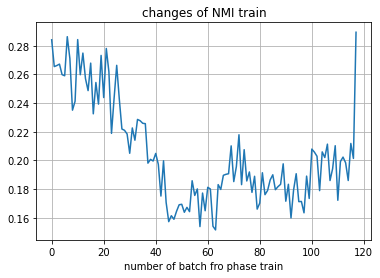

train Loss: 1.4882  Loss_ai: 1.2126  Loss_cl: 0.2756  NMI: 0.2052 epoch: 8


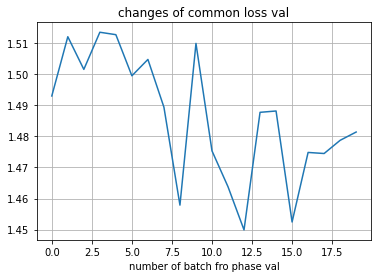

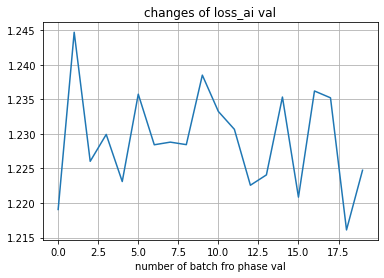

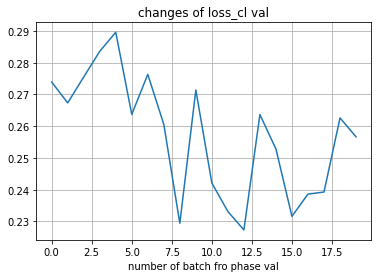

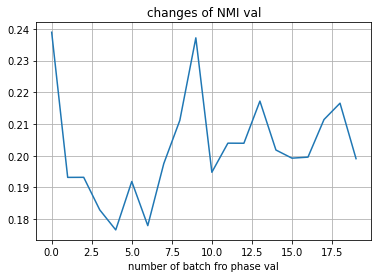

val Loss: 1.4862  Loss_ai: 1.2291  Loss_cl: 0.2570  NMI: 0.2024 epoch: 8
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


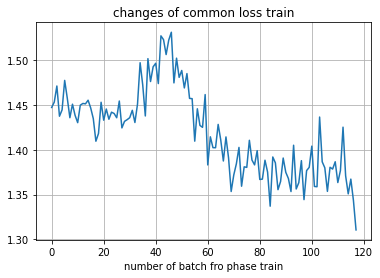

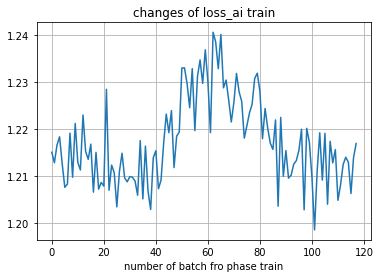

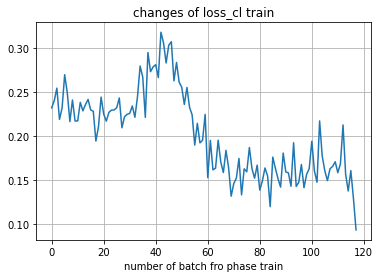

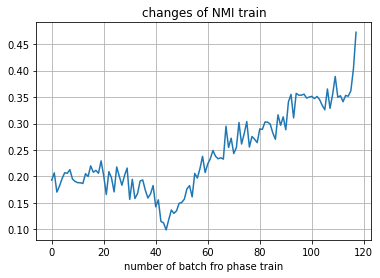

train Loss: 1.4204  Loss_ai: 1.2173  Loss_cl: 0.2023  NMI: 0.2451 epoch: 9


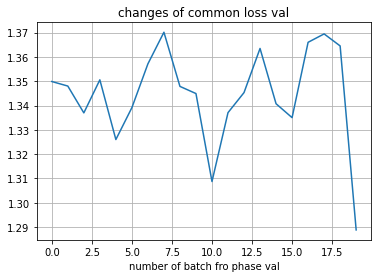

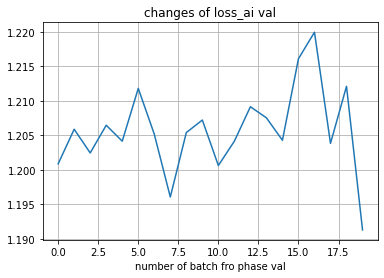

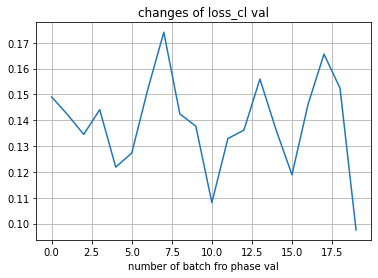

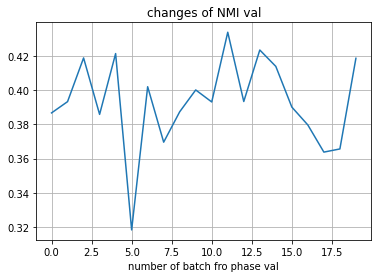

val Loss: 1.3458  Loss_ai: 1.2057  Loss_cl: 0.1388  NMI: 0.3930 epoch: 9
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


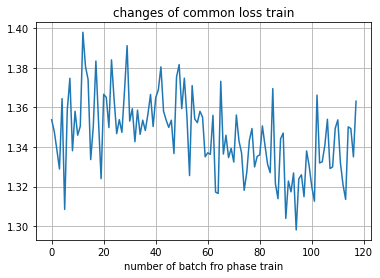

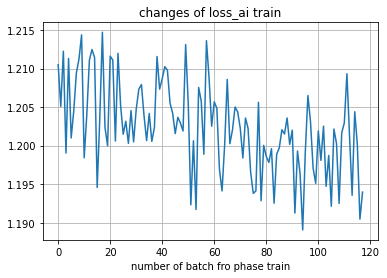

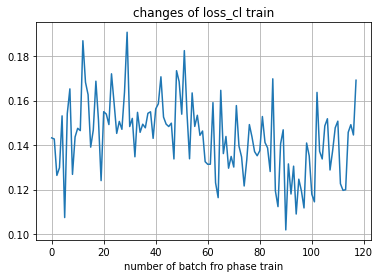

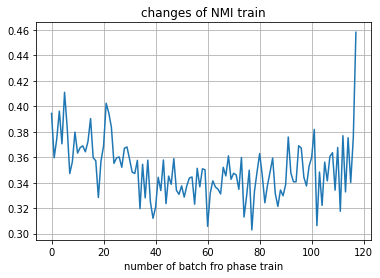

train Loss: 1.3459  Loss_ai: 1.2024  Loss_cl: 0.1436  NMI: 0.3507 epoch: 10


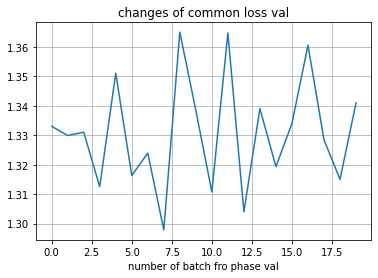

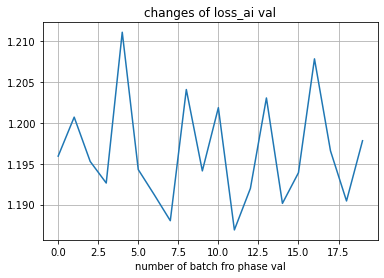

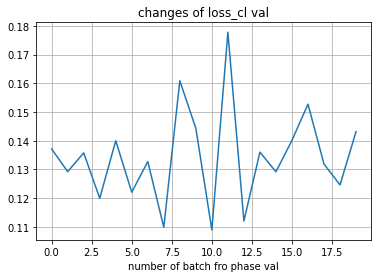

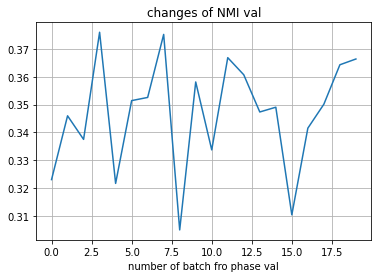

val Loss: 1.3306  Loss_ai: 1.1964  Loss_cl: 0.1344  NMI: 0.3468 epoch: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


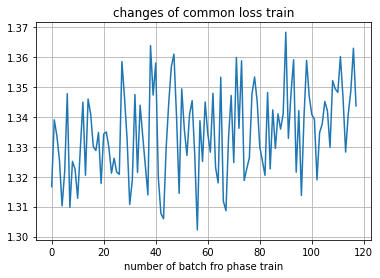

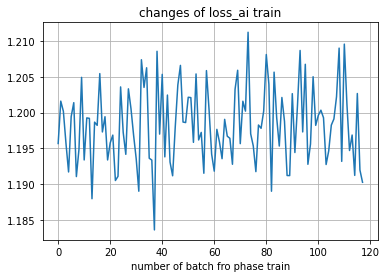

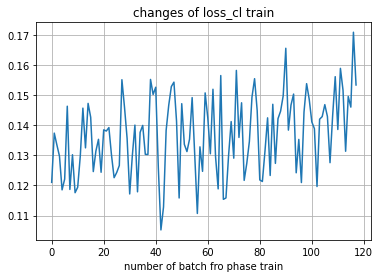

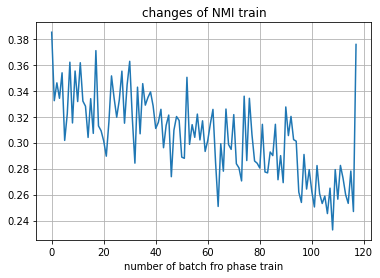

train Loss: 1.3348  Loss_ai: 1.1982  Loss_cl: 0.1366  NMI: 0.3050 epoch: 11


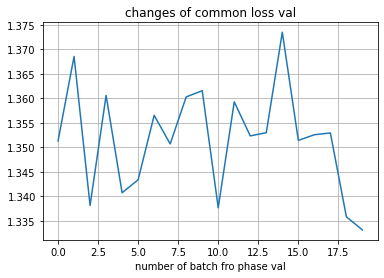

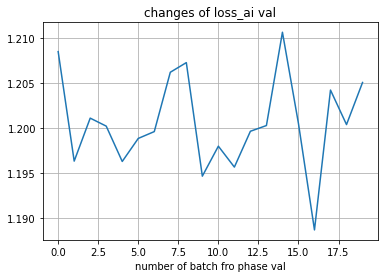

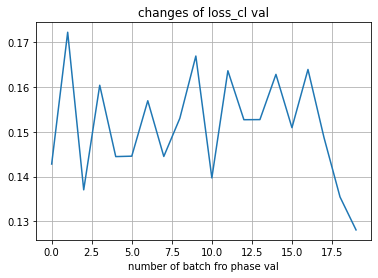

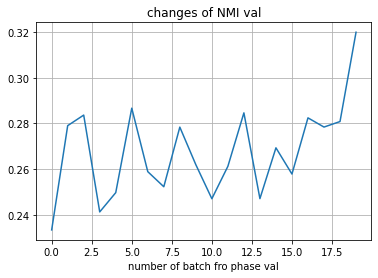

val Loss: 1.3521  Loss_ai: 1.2006  Loss_cl: 0.1511  NMI: 0.2677 epoch: 11
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


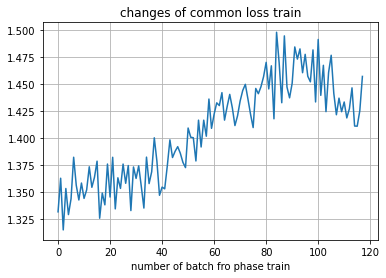

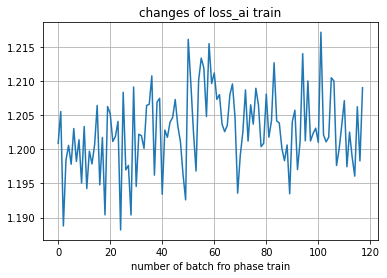

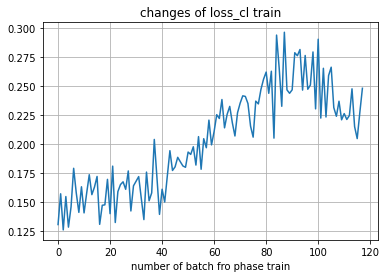

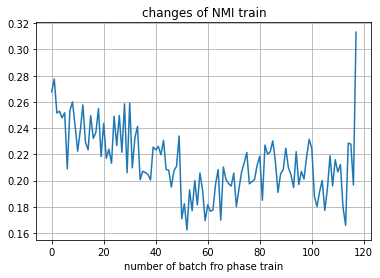

train Loss: 1.4060  Loss_ai: 1.2029  Loss_cl: 0.2035  NMI: 0.2142 epoch: 12


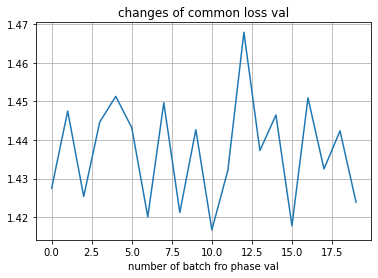

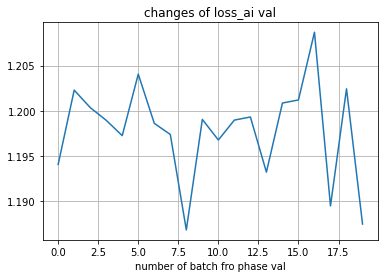

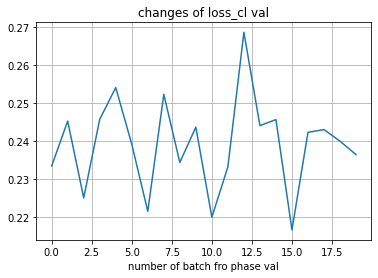

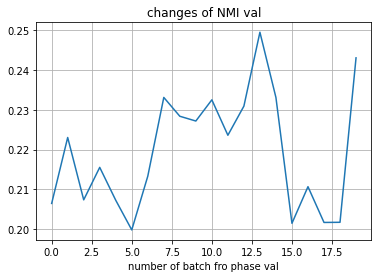

val Loss: 1.4374  Loss_ai: 1.1979  Loss_cl: 0.2392  NMI: 0.2195 epoch: 12
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


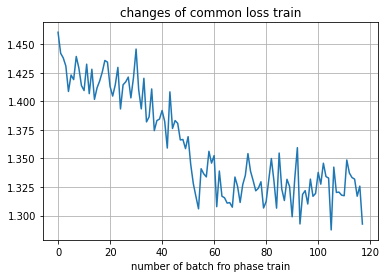

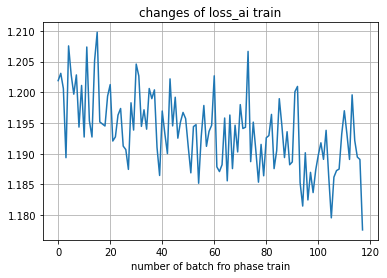

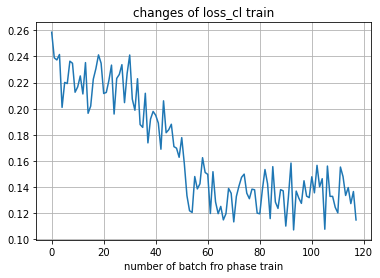

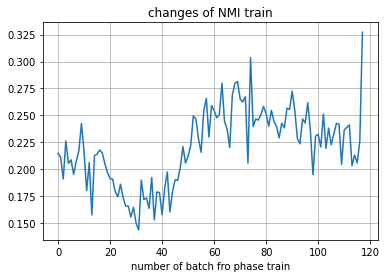

train Loss: 1.3617  Loss_ai: 1.1936  Loss_cl: 0.1676  NMI: 0.2202 epoch: 13


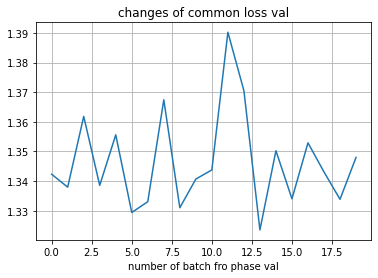

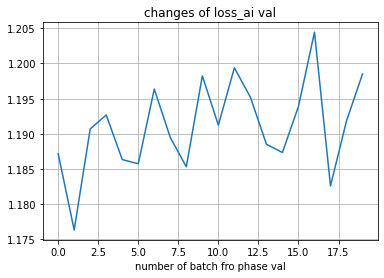

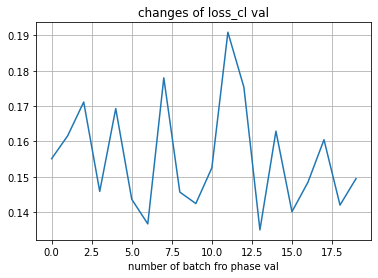

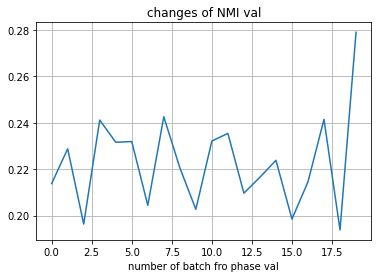

val Loss: 1.3464  Loss_ai: 1.1911  Loss_cl: 0.1553  NMI: 0.2230 epoch: 13
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10
cluster number: 10


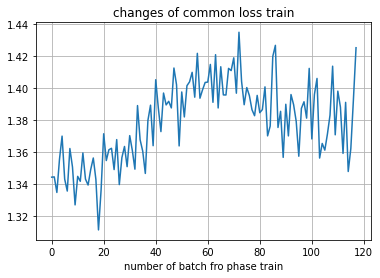

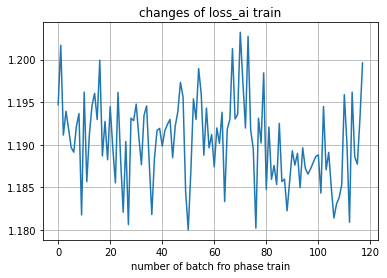

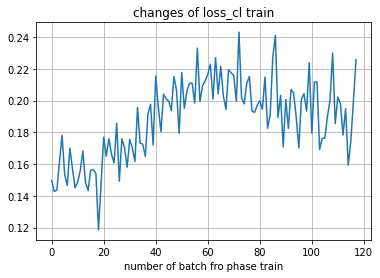

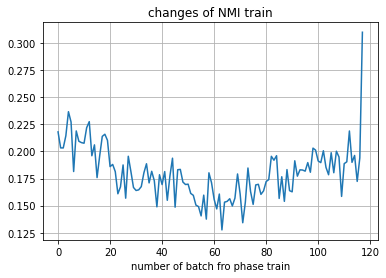

train Loss: 1.3786  Loss_ai: 1.1904  Loss_cl: 0.1885  NMI: 0.1805 epoch: 14


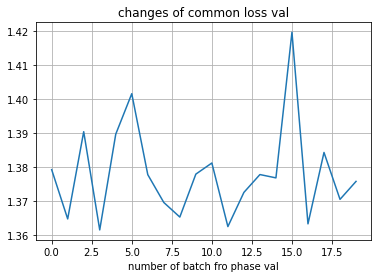

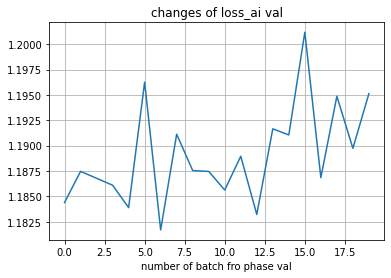

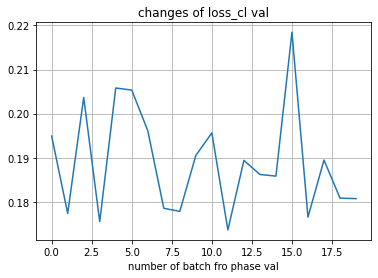

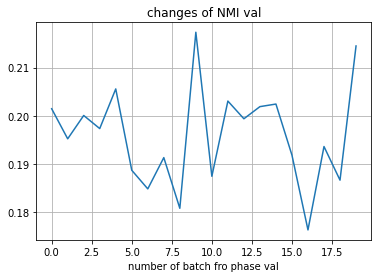

val Loss: 1.3782  Loss_ai: 1.1890  Loss_cl: 0.1891  NMI: 0.1960 epoch: 14


In [42]:
trained_model = train_model_model(model, criterion_ai, optimizer_ai, criterion_cl, epoch=15)

In [ ]:
trained_model = Autorencoder(10, 128)

In [ ]:
trained_model.load_state_dict(torch.load('./models/AICluster'))

<All keys matched successfully>

In [ ]:
trained_model = trained_model.to(device)

The result of autoincoder

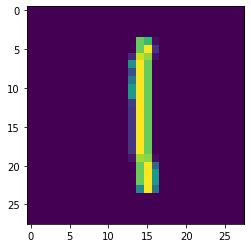

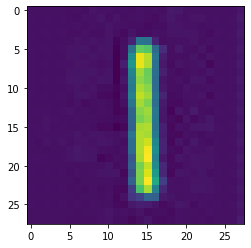

torch.Size([1, 1, 28, 28])


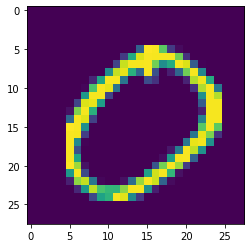

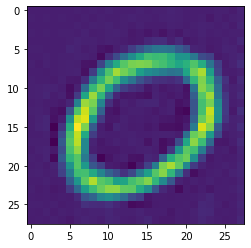

torch.Size([1, 1, 28, 28])


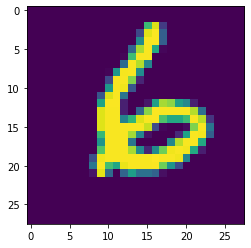

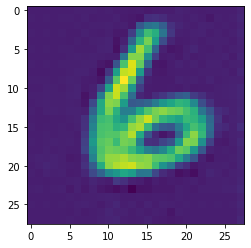

torch.Size([1, 1, 28, 28])


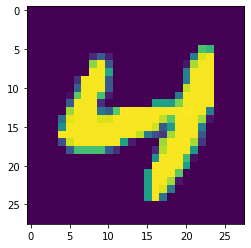

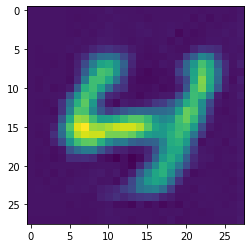

torch.Size([1, 1, 28, 28])


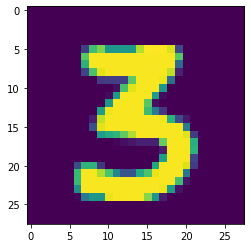

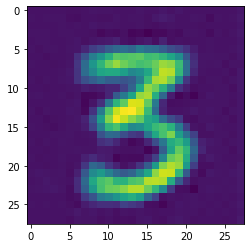

torch.Size([1, 1, 28, 28])


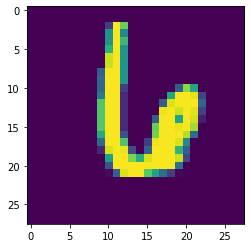

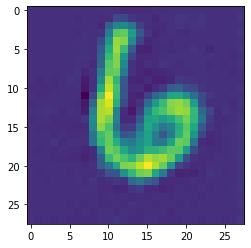

torch.Size([1, 1, 28, 28])


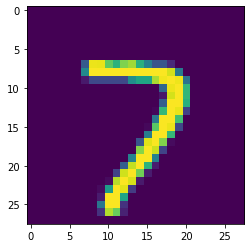

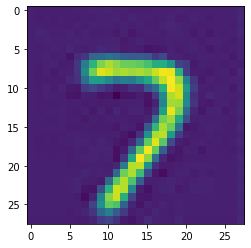

torch.Size([1, 1, 28, 28])


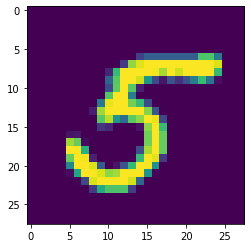

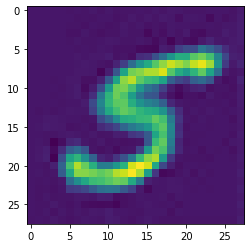

torch.Size([1, 1, 28, 28])


In [43]:
test_loader_sample = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)
idx = 0
for inputs, labels in test_loader_sample:
  inputs = inputs.to(device)
  img = inputs[0, 0, :, :].to(cpu).detach().numpy()
  plt.imshow(img)
  plt.show()
  output, _, _ = trained_model(inputs)
  img_out = output[0, 0, :, :].to(cpu).detach().numpy()
  plt.imshow(img_out)
  plt.show()
  print(output.shape)
  if idx > 6:
    break
  idx += 1

Using the ecoder layer form autoincoder model as pretrained conv layer

In [44]:
class Cnn(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ## Linear section
        self.fc1 = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128,10)
        )



 

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [45]:
cnn = Cnn()

In [55]:
cnn = Cnn()
cnn.conv1 = trained_model.encoder_cnn
for param in cnn.parameters():
  param.requires_grad = False
cnn.fc1 = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128,10)
        )
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001) 

In [56]:
def simple_traing(model, criterion, optimizer, epoch=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 5
  best_acc = 0.0

  for i in range(epoch):
    corrects = []
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          probs = model(inputs)
          _, preds = torch.max(probs, 1)
          
          loss = criterion(probs,labels)


          if (phase == 'train'):
              loss.backward()
              optimizer.step()

          corrects.append(torch.sum(preds == labels.data).double().to(cpu).detach().numpy() / inputs.size(0))

          

        running_loss += loss*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      plt.plot(corrects)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of accuracy score for phase {phase}')
      plt.show()
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model

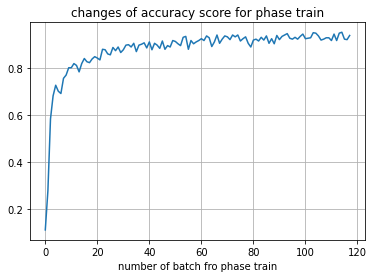

train Loss: 0.4711 Acc: 0.8780


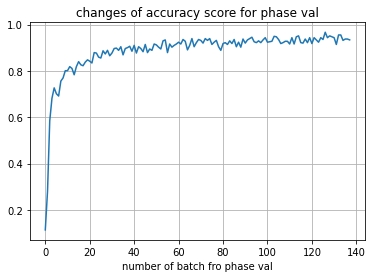

val Loss: 0.2150 Acc: 0.9391


Cnn(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [57]:
 simple_traing(cnn, criterion, optimizer, epoch=1)

Compairing the result with simple traing

In [49]:
cnn_simple = Cnn()
cnn_simple = cnn_simple.to(device)
criterion_simple = nn.CrossEntropyLoss()
optimizer_simple = optim.Adam(cnn_simple.parameters(), lr=0.001)

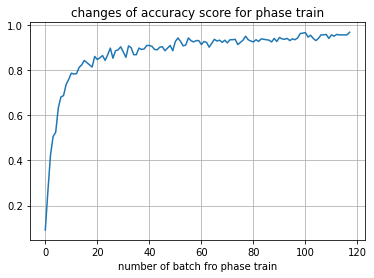

train Loss: 0.4702 Acc: 0.8794


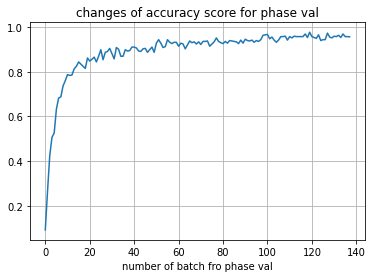

val Loss: 0.1452 Acc: 0.9565


Cnn(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [50]:
simple_traing(cnn_simple, criterion_simple, optimizer_simple, epoch=1)

**Conclution**
We can see, that in begining the model with pretrained layers has increased traing speed. That means, this method is useful wher the number of labels is not so big, but the number of available data is big